In [18]:
import numpy as np
import matplotlib.pyplot as plt
mpy = np.random.random((9,16,16,2))-0.5
m = np.squeeze(mpy[:,:,:,0])
print(m.shape)

(9, 16, 16)


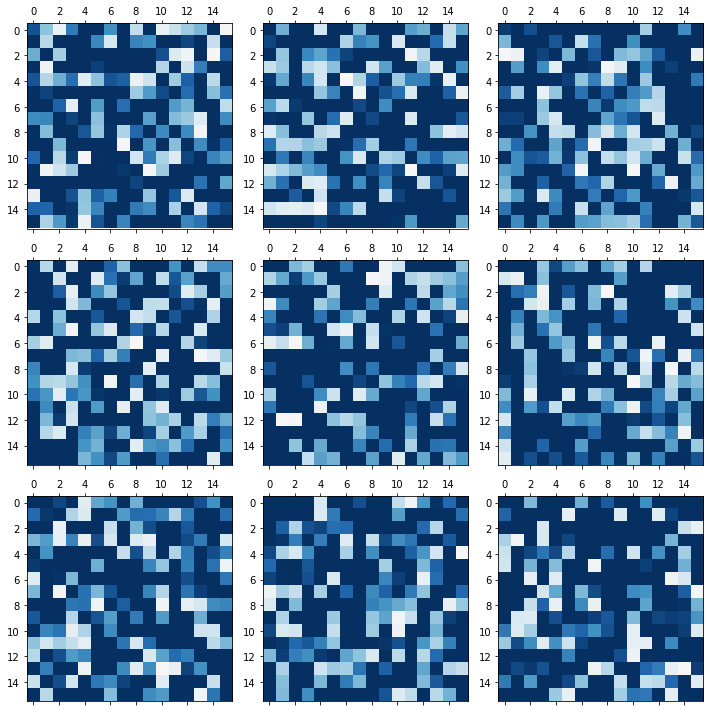

In [19]:
figure = plt.figure(figsize=(10,10))
if len(m.shape)==3:
    for i in range(min(9, m.shape[0])):
        ax = figure.add_subplot(3,3,i+1)
        im = ax.matshow(np.squeeze(m[i,:,:]), cmap='RdBu_r')
        im.set_clim(0.001, 1.001)
    plt.tight_layout()